In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# from keras.models import Sequential
# from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity

# Manual implementation of _EarlyStopping_ and comparison with _TensorFlow 2.0 EalryStopping_ callback:
Using _MNIST_ dataset

The criteria for _EarlyStopping_ depends on the following parameters:

1. Metric to be monitored
1. _min_delta_ is the minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than _min_delta_, will count as no improvement.
1. _patience_ is the number of epoch(s) without any improvements (taking into consideration that improvements have to be of a lesser change than _min_delta_) before stopping the algorithm.

NOTE:

In the code below, _val_loss_ metric is used and hence the changes have to be lesser than it to be qualified as an improvement. However, if we take _accuracy_ as the metrics, then the changes have to be greater than the 'best' accuracy to be counted as an improvement.

### Load and prepare the MNIST dataset:

In [2]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 28, 28

In [3]:
batch_size = 32
num_classes = 10
epochs = 50

In [4]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
# Add a channels dimension
# X_train = X_train[..., tf.newaxis]
# X_test = X_test[..., tf.newaxis]

if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (28, 28, 1)



In [7]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 28, 28, 1), y_train = (60000, 10)
X_test.shape = (10000, 28, 28, 1), y_test = (10000, 10)


In [9]:
# Use tf.data to batch and shuffle the dataset-
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(buffer_size=70000, reshuffle_each_iteration=True).batch(
    batch_size = batch_size, drop_remainder=False)

test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)).batch(batch_size=batch_size, drop_remainder=False)


# Create TensorFlow 2.0 dataset WITHOUT using 'shuffle'-
# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_ds = train_ds.batch(batch_size = batch_size, drop_remainder = False)

# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# test_ds = test_ds.batch(batch_size = batch_size, drop_remainder = False)

In [12]:
def create_cnn():
    """
    Function to create a simple
    CNN for MNIST classification
    """
    
    model = Sequential()
    
    model.add(
        Conv2D(
            filters = 32, kernel_size = (3, 3),
            activation = 'relu',
            kernel_initializer = tf.keras.initializers.GlorotNormal(),
            input_shape = (28, 28, 1)
        )
    )
    
    model.add(
        Flatten()
    )
    
    model.add(
        Dense(
            units = 128, activation = 'relu',
            kernel_initializer = tf.keras.initializers.GlorotNormal()
        )
    )
    
    model.add(
        Dense(
            units = 10, activation = 'softmax'
        )
    )
    
    return model
    
    

### First, _model.fit()_ is used:

In [13]:
# Instantiate an instance of CNN-
model = create_cnn()

In [14]:
# Save weights to be reused by 'GradientTape' model later-
model.save_weights("Weights/Random_Weights.h5", overwrite=True)

In [16]:
# Compile the designed nn model-
model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr = 0.001),
    metrics=['accuracy']
)

In [17]:
# Define early stopping-
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3,
    min_delta = 0.001, mode = 'min'
)

In [18]:
# Get summary details of defined model-
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2769024   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train defined model-
history_orig = model.fit(
    x = X_train, y = y_train,
    batch_size = batch_size, epochs = epochs,
    validation_data = (X_test, y_test),
    callbacks = [callback],
    verbose = 1,
    shuffle=True
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 21s 347us/sample - loss: 0.1357 - accuracy: 0.9589 - val_loss: 0.0606 - val_accuracy: 0.9799
Epoch 2/50
60000/60000 [==============================] - 19s 316us/sample - loss: 0.0417 - accuracy: 0.9874 - val_loss: 0.0497 - val_accuracy: 0.9854
Epoch 3/50
60000/60000 [==============================] - 18s 308us/sample - loss: 0.0233 - accuracy: 0.9925 - val_loss: 0.0610 - val_accuracy: 0.9816
Epoch 4/50
60000/60000 [==============================] - 18s 307us/sample - loss: 0.0139 - accuracy: 0.9954 - val_loss: 0.0548 - val_accuracy: 0.9845
Epoch 5/50
60000/60000 [==============================] - 18s 296us/sample - loss: 0.0098 - accuracy: 0.9966 - val_loss: 0.0627 - val_accuracy: 0.9833


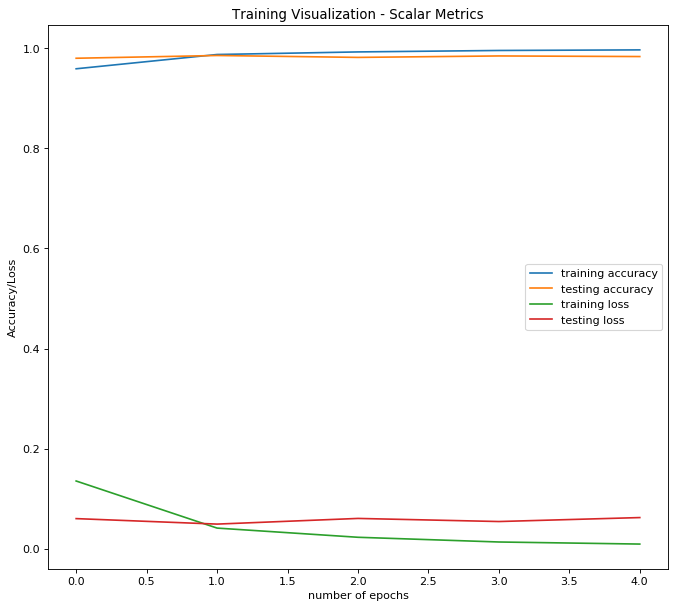

In [20]:
# Visualize training progress of neural network model-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_orig.history['accuracy'], label = 'training accuracy')
plt.plot(history_orig.history['val_accuracy'], label = 'testing accuracy')
plt.plot(history_orig.history['loss'], label = 'training loss')
plt.plot(history_orig.history['val_loss'], label = 'testing loss')

plt.title("Training Visualization - Scalar Metrics")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc = 'best')
plt.show()


In [21]:
score_orig = model.evaluate(X_test, y_test, verbose=0)

In [22]:
print("\n'model.fit()' metrics on testing set:")
print("loss = {0:.4f} & accuracy = {1:.4f}\n".format(
    score_orig[0], score_orig[1]))


'model.fit()' metrics on testing set:
loss = 0.0627 & accuracy = 0.9833



In [23]:
# Make predictions using trained model-
y_pred_orig = model.predict_classes(X_test)

In [24]:
# Convert from one-hot encoded to labels-
y_test_labels = np.argmax(y_test, axis=1)

In [25]:
# Compute metrics-
accuracy_orig = accuracy_score(y_test_labels, y_pred_orig)
precision_orig = precision_score(y_test_labels, y_pred_orig, average='macro')
recall_orig = recall_score(y_test_labels, y_pred_orig, average='macro')

In [26]:
print("\n'model.fit()' metrics on testing dataset are:")
print("accuracy = {0:.4f}, precision = {1:.4f} & recall = {2:.4f}\n".format(
    accuracy_orig, precision_orig, recall_orig))


'model.fit()' metrics on testing dataset are:
accuracy = 0.9833, precision = 0.9832 & recall = 0.9831



In [27]:
print("\n'model.fit()' confusion matrix:\n")
print(confusion_matrix(y_test_labels, y_pred_orig))


'model.fit()' confusion matrix:

[[ 973    1    1    0    0    2    2    1    0    0]
 [   2 1130    1    0    0    0    1    0    1    0]
 [   0    2 1015    3    0    0    0    8    4    0]
 [   0    0    1  996    0    5    0    0    7    1]
 [   1    0    3    0  972    0    2    0    0    4]
 [   2    0    1   12    0  875    2    0    0    0]
 [   7    2    2    1    5    4  935    0    2    0]
 [   1    2    5    2    0    0    0 1013    2    3]
 [   5    1    1    2    2    5    0    5  949    4]
 [   6    5    0    6    7    5    0    2    3  975]]


### Now, _GradientTape_ is used:

In [53]:
# Instantiate a model-
model_gt = create_cnn()

In [54]:
# Restore random weights as used by the previous model for fair comparison-
model_gt.load_weights("Weights/Random_Weights.h5")

In [55]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.001)

In [56]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

In [57]:
# Use tf.GradientTape to train the model-

@tf.function
def train_step(data, labels):
    """
    Function to perform one step of Gradient
    Descent optimization
    """

    with tf.GradientTape() as tape:
        predictions = model_gt(data)
        loss = loss_fn(labels, predictions)

    gradients = tape.gradient(loss, model_gt.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_gt.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

    

In [58]:
@tf.function
def test_step(data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model_gt(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [59]:
# User input-
minimum_delta = 0.001
patience = 5

# value of 'best' loss value-
best_val_loss = 1

# variable to keep track of number of epochs
# without any improvement in monitored metric-
loc_patience = 0

# patience_val = np.zeros(patience)

In [60]:
# Dictionary to hold scalar metrics-
history = {}

history['accuracy'] = np.zeros(epochs)
history['val_accuracy'] = np.zeros(epochs)
history['loss'] = np.zeros(epochs)
history['val_loss'] = np.zeros(epochs)

In [61]:
for epoch in range(epochs):
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
        
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for x, y in train_ds:
        train_step(x, y)

    for x_t, y_t in test_ds:
        test_step(x_t, y_t)

    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
    history['accuracy'][epoch] = train_accuracy.result()
    history['loss'][epoch] = train_loss.result()
    history['val_loss'][epoch] = test_loss.result()
    history['val_accuracy'][epoch] = test_accuracy.result()

    print(template.format(epoch + 1, 
                          train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))

    
    # Code for manual Early Stopping:
    if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = test_loss.result()
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.1334, Accuracy: 99.2302, Test Loss: 0.0616, Test Accuracy: 99.609962
Epoch 2, Loss: 0.0413, Accuracy: 99.7466, Test Loss: 0.0556, Test Accuracy: 99.631950
Epoch 3, Loss: 0.0213, Accuracy: 99.8646, Test Loss: 0.0539, Test Accuracy: 99.666954
Epoch 4, Loss: 0.0134, Accuracy: 99.9130, Test Loss: 0.0604, Test Accuracy: 99.676941
Epoch 5, Loss: 0.0095, Accuracy: 99.9377, Test Loss: 0.0624, Test Accuracy: 99.698929
Epoch 6, Loss: 0.0068, Accuracy: 99.9549, Test Loss: 0.0652, Test Accuracy: 99

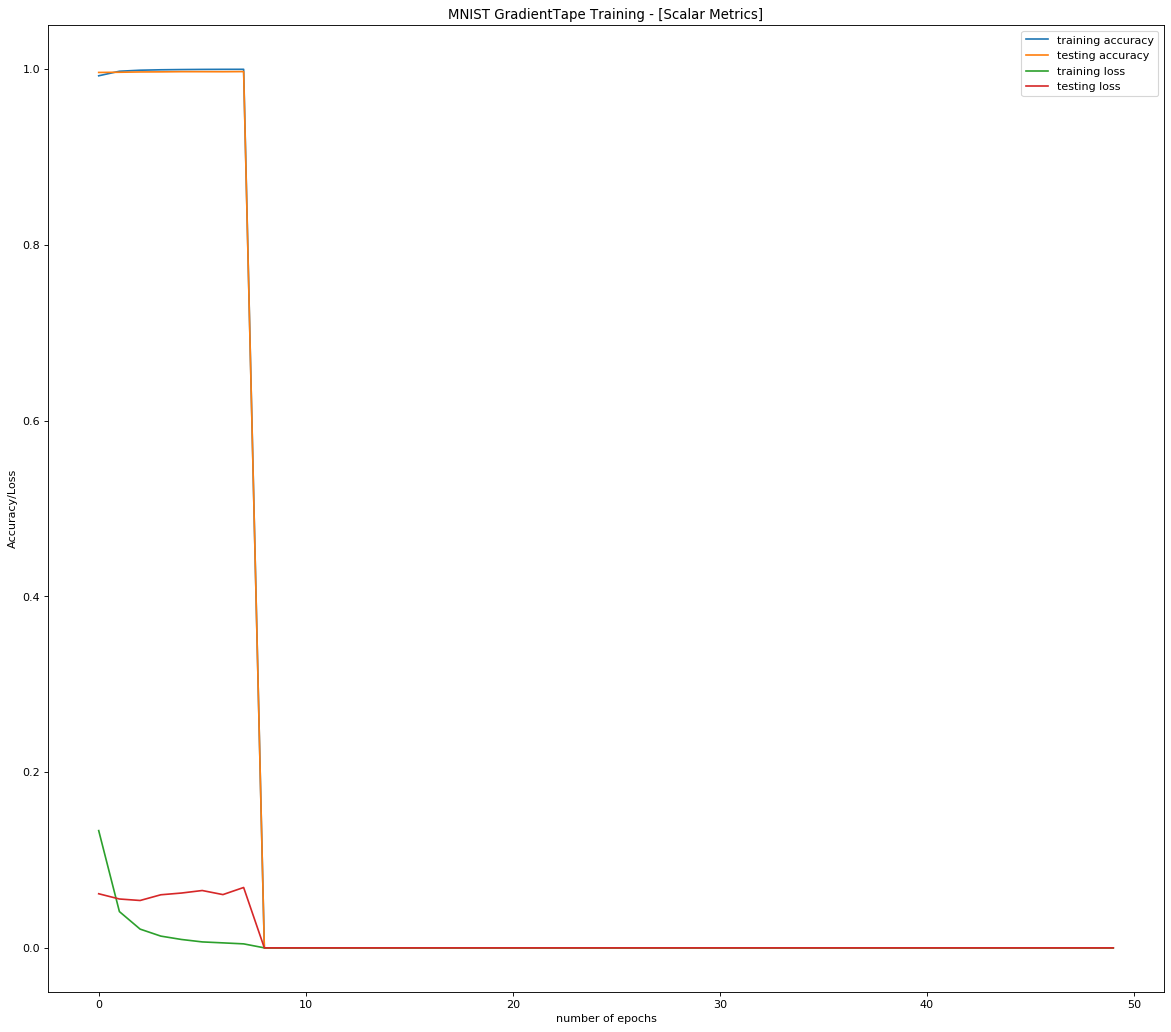

In [64]:
# Visualize scalar metrics of training process for GradientTape method-

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history['accuracy'], label = 'training accuracy')
plt.plot(history['val_accuracy'], label = 'testing accuracy')
plt.plot(history['loss'], label = 'training loss')
plt.plot(history['val_loss'], label = 'testing loss')

plt.title("MNIST GradientTape Training - [Scalar Metrics]")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc = 'best')
plt.show()

In [65]:
# Make predictions using trained model-
y_pred_gt = model_gt.predict_classes(X_test)

In [66]:
# Compute metrics-
accuracy_gt = accuracy_score(y_test_labels, y_pred_gt)
precision_gt = precision_score(y_test_labels, y_pred_gt, average='macro')
recall_gt = recall_score(y_test_labels, y_pred_gt, average='macro')

In [67]:
print("\n'GradientTape' metrics on testing dataset are:")
print("accuracy = {0:.4f}, precision = {1:.4f} & recall = {2:.4f}\n".format(
    accuracy_gt, precision_gt, recall_gt))


'GradientTape' metrics on testing dataset are:
accuracy = 0.9854, precision = 0.9853 & recall = 0.9853



In [68]:
print("\n'model.fit()' metrics on testing dataset are:")
print("accuracy = {0:.4f}, precision = {1:.4f} & recall = {2:.4f}\n".format(
    accuracy_orig, precision_orig, recall_orig))


'model.fit()' metrics on testing dataset are:
accuracy = 0.9833, precision = 0.9832 & recall = 0.9831



In [70]:
# Save weights of 'GradientTape' trained model-
model_gt.save_weights("Weights/Trained_GradientTape_model_weights.h5", overwrite=True)

In [69]:
# Save weights of 'model.fit()' trained model-
model.save_weights("Weights/Trained__modelfit_weights.h5", overwrite=True)